In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import math

In [2]:
#read file to input
df = pd.read_csv('data_banknote_authentication.txt', sep=',', header = None)
X = df.to_numpy()
y = df[4].to_numpy()
X = X[:, :4]

In [3]:
class node: 
    #instance attributes
    def __init__(self, data, parent = None, majority_label = None):
        # data contains a feature for inner nodes and the label for every leaf
        self.data = data
        self.parent = parent
        self.majority_label = majority_label
        #if children is empty, the node is a leaf -> data contains a label
        self.children = [] #map value -> node // list of tuples
    def __str__(self):
        return f"{self.data} - {self.children}"
    def addChild(self, child):
        self.children.append(child)
def printTree(node, level=0):
    if node != None:
        if node.children != []:
            printTree(node.children[0][0], level + 1)
        if node.children != []:
            print(' ' * 4 * level + '->', node.data, " : ", node.children[0][1])
        else:
            print(' ' * 4 * level + '->', node.data)
        if node.children != []:
            printTree(node.children[1][0], level + 1)

In [4]:
def learn(X, y, impurity_measure, pruning):
    seed = 130
#check pruning/training rate   
    if pruning:
        X_train, X_prun, Y_train, Y_prun = model_selection.train_test_split(X, y, test_size= 0.3, shuffle=True,                                                                                 random_state = seed)
        root = learn_rec(np.array(X_train), np.array(Y_train), [], impurity_measure) 
        root = pruning_function(root, np.array(X_prun), np.array(Y_prun))
    else:
        root = learn_rec(X, y, [], impurity_measure) 
    return root

def learn_rec(X, y, used_features, impurity_measure):
    #Ensure used_feature is of type list
    used_feature_list = np.array(used_features)
    if same_value(y):
        #create a leaf with the label -> all labels are the same so we pick an arbitrary label
        return node(y[0])
        #leaf with most common label
    elif same_value(X):
        label = get_maj_label(y)
        return node(label)
    else:
        #select the desired feature based on impurity measure
        feature = max_information_gain(X, y, impurity_measure, used_feature_list)
        used_feature_list = np.append(used_feature_list, feature)
        #create feature node and split the dataset
        f_node = node(feature, majority_label = get_maj_label(y))
        X_right, X_left, y_right, y_left, val_avg = split_dataset(X, y, feature)
        #create child nodes and set their parents
        right_child = learn_rec(np.array(X_right), y_right,  used_feature_list, impurity_measure)
        right_child.parent = f_node

        left_child = learn_rec(np.array(X_left), y_left,  used_feature_list, impurity_measure)
        left_child.parent = f_node
        #add children to featurenode
        f_node.addChild([left_child, val_avg])
        f_node.addChild([right_child, val_avg])
        return f_node


def predict(node, x):
    #empty children list
    if (not node.children):
        return node.data
    #else: recursion
    count_values = len(node.children)
    for i in range(count_values):              
        if(x[node.data] <= node.children[i][1]):           
            return predict(node.children[i][0],x)  
        #Last value in list --> x > elements in this tree
        elif(i==count_values-1):                    
            return predict(node.children[i][0], x)                   

def pruning_function(node, X_prun, y_prun):
    #Goto leafs
    if(len(X_prun) == 0): return node
    elif (len(node.children)!=0):
        X_right, X_left, y_right, y_left, val_avg = split_dataset(X_prun, y_prun, node.data)  
        pruning_function(node.children[0][0], np.array(X_left), y_left)
        pruning_function(node.children[1][0], np.array(X_right), y_right)
    else:
        #reached leaf
        return node
    #Is not leaf --> Go back up the tree
    if (acc(node, X_prun, y_prun) < majority_label_acc(node.majority_label, y_prun)):
        node.data = node.majority_label
        node.children = []
    return node

In [5]:
#hilfsfunktionen
def same_value(list_in):
    flat_array = np.ravel(list_in)
    return np.all(list_in==flat_array[0])
def common_label(y):
    dict = {} 
    count = 0
    item_ret = ''
    for item in y: 
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count : 
            count, item_ret = dict[item], item 
    return(item_ret) 
def sort_with_index(liste):
    temp_list = [ (liste[i],i) for i in range(len(liste)) ]
    temp_list.sort()
    return zip(*temp_list)

def split_indices(index, y):
    splitpoints = []
    temp = index[0]
    for i in range(len(index)):
        if y[index[i]] != y[temp]:
            #add current pair
            splitpoints.append([temp, index[i]])
            #start with next featurepoint
            temp = index[i+1]
    return splitpoints
def max_information_gain(X, y, impurity_measure = 'entropy', used_feature=[]):
    max_ig = 0
    max_label = 0
    Feature_indizes = []
    for i in range(len(X[0])):
        if(i not in used_feature):
            Feature_indizes.append(i)
    for i in Feature_indizes:
        x = X[:, i]
        ig = information_gain(x, y, impurity_measure)
        if ig > max_ig:
            max_ig = ig
            max_label = i
    return max_label
def split_dataset(X, y, feature):
    feature_values = X[:, feature]
    average = np.average(feature_values)
    X_right = []
    X_left = []
    y_right = []
    y_left = []
    for i in range(len(feature_values)):
        if feature_values[i] <= average:
            X_left.append(X[i])
            y_left.append(y[i])
        else:
            X_right.append(X[i])
            y_right.append(y[i])
    return X_right, X_left, y_right, y_left, average
def get_maj_label(y):
    label_list = []
    count_list = []
    for i in range(len(y)):
        if (y[i] not in label_list): 
            label_list.append(y[i])
            count_list.append(1)
        else:
            for j in range(len(label_list)):
                if(y[i]==label_list[j]): count_list[j]+=1
    return label_list[np.argmax(count_list)]
def majority_label_acc(majority_label, y_prun):
    x = 0
    for i in range(len(y_prun)):
        if(y_prun[i]==majority_label):
            x += 1
    return float(x) / len(y_prun)

def acc(node, X, Y):
    x = 0
    for i in range(len(Y)):
        if(Y[i]==predict(node, X[i])):
            x += 1
    return float(x) / len(Y)

In [6]:
#Implementation of Impurity-Measures
def information_gain(x, y, impurity_measure="entropy"):
    #Calculate mean value of x
    mean = 0
    count = 0
    for i in range(len(x)):
        mean += x[i]
        count +=1
    mean /= count

    #compute list of label_values for x<=mean or x>mean + probability of x <= mean
    leq_mean = []
    g_mean = []
    count_leq_mean = 0
    for i in range(len(x)):
        if(x[i] <= mean):
            count_leq_mean +=1
            leq_mean.append(y[i])
        else:
            g_mean.append(y[i])
    prob_leq_mean = count_leq_mean / count

    #compute H(y), H(y|x)
    if(impurity_measure=="entropy"):
        impurity = entropy(y)
        conditional_impurity = prob_leq_mean * entropy(leq_mean)+ (1-prob_leq_mean) * entropy(g_mean)
    elif(impurity_measure=="gini"):
        impurity = gini(y)
        conditional_impurity = prob_leq_mean * gini(leq_mean)+ (1-prob_leq_mean) * gini(g_mean) 
    else:
        print("Not known impurity measure")

    #Information gain IG = H(y) - H(y|x)
    return impurity - conditional_impurity

def probabiliy_list(values):
    count_values = len(values)
    value_list = []
    prob_list = []
    different_val = 0
    #compute list of the count of different values (unsorted)
    for i in range(count_values):
        if (values[i] not in value_list): 
            value_list.append(values[i])
            prob_list.append(1)
            different_val +=1
        else:
            for j in range(different_val):
                if(values[i]==value_list[j]): prob_list[j]+=1
    #get probabilities of different values by count[value] / count_all_values
    for k in range(different_val):
        prob_list[k] = float(prob_list[k]) / count_values
    #Remark: this is an unsorted list of only the probabilities --> no information about the original values
    return prob_list 

def entropy(values):
    prob_list = probabiliy_list(values)
    different_values = len(prob_list)
    sum = 0
    for i in range(different_values):
        sum -= math.log(prob_list[i], 2) * prob_list[i]
    return sum

def gini(values):
    prob_list = probabiliy_list(values)
    different_values = len(prob_list)
    sum = 0
    for i in range(different_values):
        sum += prob_list[i]*(1-prob_list[i])
    return sum

In [7]:
#Unused help functions
def delete_column(x,index):
    return np.delete(x,index,0)
def delete_feature_from_matrix(X, Feature_index):
    return np.delete(X, Feature_index, 1)#Feature is Axis 1


pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning
pruning


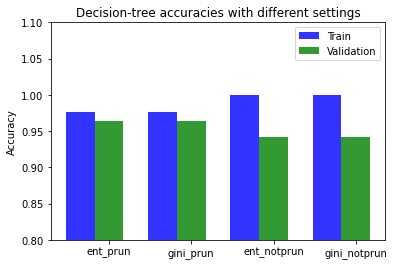

[0.9762989972652689, 0.9762989972652689, 1.0, 1.0]
[0.9635036496350365, 0.9635036496350365, 0.9416058394160584, 0.9416058394160584]


In [8]:
#Evaluation
seed = 749
X_train, X_val_test, Y_train, Y_val_test = model_selection.train_test_split(X, y, test_size= 0.2, shuffle=True,                                                                                     random_state = seed)
seed = 412
X_val, X_test, Y_val, Y_test = model_selection.train_test_split(X_val_test, Y_val_test, test_size= 0.5,                                                                                              shuffle=True,                                                                                                    random_state = seed)
#We now have ratio training-, validation-, testdata: 0.7, 0.15, 0.15

#Train decisiontree using entropy + pruning
tree_ent_prun = learn(X_train, Y_train, impurity_measure="entropy", pruning=True)
val_acc_ent_prun = acc(tree_ent_prun, X_val, Y_val)
train_acc_ent_prun = acc(tree_ent_prun, X_train, Y_train)
#printTree(tree_ent_prun)

#Train decisiontree using gini + pruning
tree_gini_prun = learn(X_train, Y_train, impurity_measure="gini", pruning=True)
val_acc_gini_prun = acc(tree_gini_prun, X_val, Y_val)
train_acc_gini_prun = acc(tree_gini_prun, X_train, Y_train)

#Train decisiontree using entropy and not pruning
tree_ent_notprun = learn(X_train, Y_train, impurity_measure="entropy", pruning=False)
val_acc_ent_notprun = acc(tree_ent_notprun, X_val, Y_val)
train_acc_ent_notprun = acc(tree_ent_notprun, X_train, Y_train)
#printTree(tree_ent_notprun)

#Train decisiontree using gini and not pruning
tree_gini_notprun = learn(X_train, Y_train, impurity_measure="gini", pruning=False)
val_acc_gini_notprun = acc(tree_gini_notprun, X_val, Y_val)
train_acc_gini_notprun = acc(tree_gini_notprun, X_train, Y_train)

#plot accuracies
settings_list = ["ent_prun", "gini_prun","ent_notprun", "gini_notprun"]
train_accuracies = [train_acc_ent_prun, train_acc_gini_prun, train_acc_ent_notprun, train_acc_gini_notprun]
val_accuracies = [val_acc_ent_prun, val_acc_gini_prun, val_acc_ent_notprun, val_acc_gini_notprun]
index=np.arange(4)
bar_width=0.35
bar1 = plt.bar(index, train_accuracies,bar_width, alpha=0.8, color="b", label="Train_acc")
bar2 = plt.bar(index+bar_width, val_accuracies,bar_width, alpha=0.8, color="g", label="Val_acc")

plt.ylim(0.8, 1.1)
plt.xticks(index+bar_width, settings_list)
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='best')
plt.title("Decision-tree accuracies with different settings")
plt.show()

print(train_accuracies)
print(val_accuracies)

In [9]:
#Testing
#Choose ent_prun
test_acc = acc(tree_ent_prun, X_test, Y_test)
print("Test accuracy: "+str(test_acc))

Test accuracy: 0.9565217391304348


In [10]:
#Comparison with existing implementations
#Use Entropy but not pruning
DecisionTree = DecisionTreeClassifier(criterion="entropy")
DecisionTree.fit(X_train, Y_train)
sklearn_tree_train_acc = DecisionTree.score(X_train, Y_train)
sklearn_tree_val_acc = DecisionTree.score(X_val, Y_val)
sklearn_tree_test_acc = DecisionTree.score(X_test, Y_test)
print("Training accuracy: "+str(sklearn_tree_train_acc))
print("Validation accuracy: "+str(sklearn_tree_val_acc)) 
print("Test accuracy: "+str(sklearn_tree_test_acc))

Training accuracy: 1.0
Validation accuracy: 0.9854014598540146
Test accuracy: 0.9927536231884058
